# 04 — Evaluation & Reporting

This notebook packages the results:
1. Load processed artifacts (detrended light curve + BLS parameters).
2. Recreate key plots (BLS periodogram, phase-folded light curve).
3. Save figures under `reports/figures/`.
4. Generate a concise project report (`reports/RESULTS.md`).

Artifacts expected from previous notebooks:
- `data/processed/detrended_lightcurve.csv`
- `data/processed/bls_results.csv`


### Step 1 — Load processed artifacts


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

PROC = Path(r"E:\Data science\projects\exoplanet-discovery\data\processed")
FIGS = Path(r"E:\Data science\projects\exoplanet-discovery\reports\figures")
FIGS.mkdir(parents=True, exist_ok=True)

lc = pd.read_csv(PROC / "detrended_lightcurve.csv").dropna().sort_values("time")
bls = pd.read_csv(PROC / "bls_results.csv").iloc[0]

P   = float(bls["period_days"])
t0  = float(bls["t0_bkjd"])
dur = float(bls["duration_days"])
snr = float(bls["snr"])
depth_ppm = float(bls["depth_ppm"])

print(f"Loaded: N={len(lc)}  |  P={P:.6f} d, t0={t0:.4f}, dur={dur:.4f} d, SNR={snr:.2f}, depth≈{depth_ppm:.1f} ppm")


Loaded: N=1432  |  P=0.837538 d, t0=131.5723, dur=0.0700 d, SNR=2.55, depth≈165.0 ppm


### Step 2 — Recreate the BLS periodogram and save it


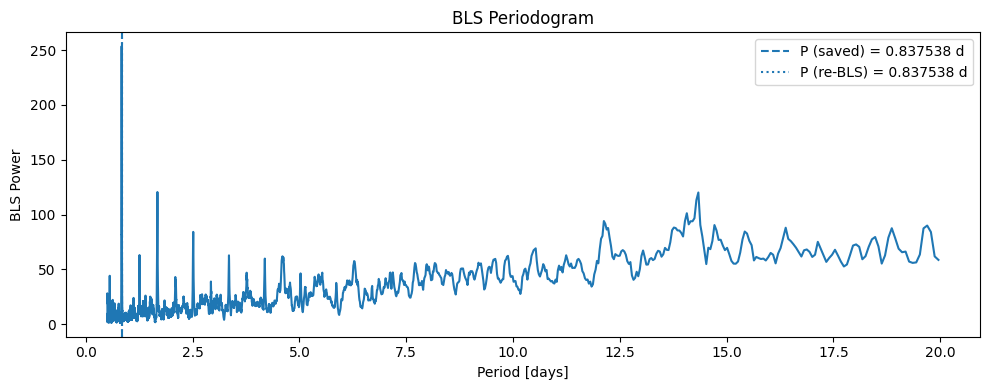

Saved: E:\Data science\projects\exoplanet-discovery\reports\figures\bls_periodogram.png


In [2]:
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares

t = lc["time"].to_numpy(dtype=float)
f = lc["flux"].to_numpy(dtype=float)
# Bring baseline near 1.0 for BLS stability
if np.nanmean(f) < 0.5: 
    f = 1.0 + f
dy = np.full_like(f, np.nanstd(f))

timespan = t.max() - t.min()
min_period = max(0.5, 3*np.median(np.diff(t)))
max_period = min(20.0, 0.9*timespan)
durations = np.linspace(0.05, 0.25, 12)

bls_op = BoxLeastSquares(t, f, dy)
res = bls_op.autopower(durations, minimum_period=min_period, maximum_period=max_period, frequency_factor=5.0)

best_idx = np.argmax(res.power)
best_period = float(res.period[best_idx])

plt.figure(figsize=(10,4))
plt.plot(res.period, res.power)
plt.axvline(P, ls="--", label=f"P (saved) = {P:.6f} d")
plt.axvline(best_period, ls=":", label=f"P (re-BLS) = {best_period:.6f} d")
plt.xlabel("Period [days]")
plt.ylabel("BLS Power")
plt.title("BLS Periodogram")
plt.legend()
plt.tight_layout()
plt.savefig(FIGS / "bls_periodogram.png", dpi=160)
plt.show()

print("Saved:", FIGS / "bls_periodogram.png")


### Step 3 — Phase-folded light curve (raw & binned) and save figures


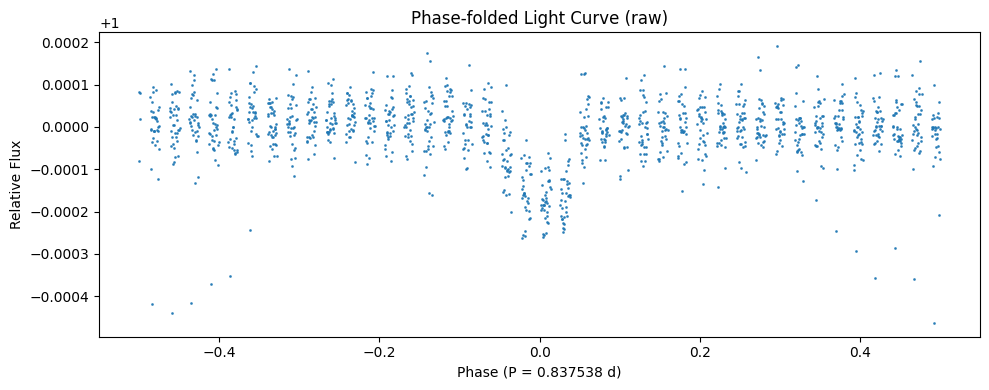

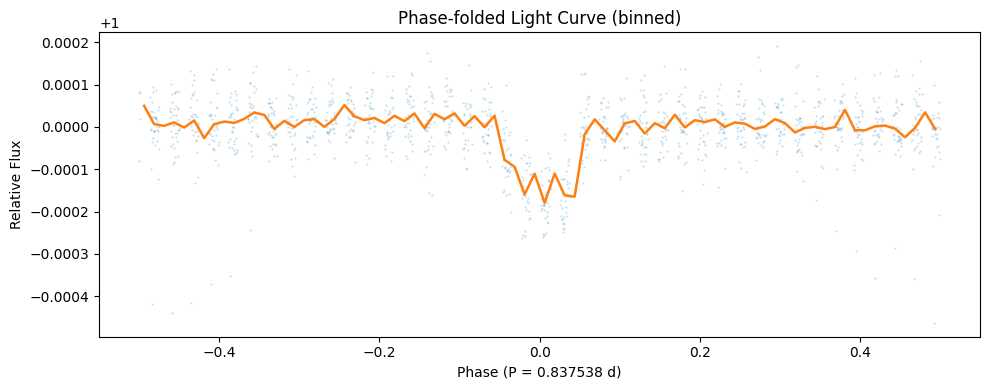

Saved: E:\Data science\projects\exoplanet-discovery\reports\figures\phase_folded_raw.png
Saved: E:\Data science\projects\exoplanet-discovery\reports\figures\phase_folded_binned.png


In [3]:
# Phase folding at saved best period P and t0
phase = ((t - t0 + 0.5*P) % P) / P - 0.5
order = np.argsort(phase)

plt.figure(figsize=(10,4))
plt.plot(phase[order], f[order], ".", markersize=2, alpha=0.8)
plt.xlabel(f"Phase (P = {P:.6f} d)")
plt.ylabel("Relative Flux")
plt.title("Phase-folded Light Curve (raw)")
plt.tight_layout()
plt.savefig(FIGS / "phase_folded_raw.png", dpi=160)
plt.show()

# Binning for clarity
nbin = 80
bins = np.linspace(-0.5, 0.5, nbin+1)
inds = np.digitize(phase, bins) - 1
bin_phase = 0.5*(bins[:-1] + bins[1:])
bin_flux  = np.array([np.nanmedian(f[inds==i]) for i in range(nbin)])

plt.figure(figsize=(10,4))
plt.plot(phase, f, ".", markersize=1, alpha=0.25)
plt.plot(bin_phase, bin_flux, "-", lw=1.8)
plt.xlabel(f"Phase (P = {P:.6f} d)")
plt.ylabel("Relative Flux")
plt.title("Phase-folded Light Curve (binned)")
plt.tight_layout()
plt.savefig(FIGS / "phase_folded_binned.png", dpi=160)
plt.show()

print("Saved:", FIGS / "phase_folded_raw.png")
print("Saved:", FIGS / "phase_folded_binned.png")


### Step 4 — Generate a short Markdown report


In [4]:
report_path = Path(r"E:\Data science\projects\exoplanet-discovery\reports\RESULTS.md")

report_md = f"""# Exoplanet Candidate — Results

This report summarizes the outcome of our transit search.

## Key Parameters
- **Best period:** {P:.6f} days  
- **Transit duration:** {dur*24.0:.2f} hours  
- **Transit depth:** ~{depth_ppm:.1f} ppm  
- **SNR:** {snr:.2f}  

## Figures
- BLS Periodogram: `reports/figures/bls_periodogram.png`  
- Phase-folded (raw): `reports/figures/phase_folded_raw.png`  
- Phase-folded (binned): `reports/figures/phase_folded_binned.png`  

## Notes
- Period aliases and harmonics should be checked (P/2, 2P).
- The candidate appears to show a repeatable, U-shaped dip near phase 0.
- Future work: vetting tests, stellar parameter cross-match, and ML-based ranking on a larger sample.
"""

report_path.write_text(report_md, encoding="utf-8")
print("Saved report:", report_path)


Saved report: E:\Data science\projects\exoplanet-discovery\reports\RESULTS.md
